In [1]:
import sys
from pathlib import Path

# Find repo root by walking up until we see /src
cwd = Path.cwd().resolve()

repo_root = None
for p in [cwd] + list(cwd.parents):
    if (p / "src").exists():
        repo_root = p
        break

if repo_root is None:
    raise FileNotFoundError(
        f"Could not find repo root containing a 'src' folder. CWD is: {cwd}"
    )

# Add repo root to path (so `import src...` works)
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

print("✅ CWD:", cwd)
print("✅ Repo root:", repo_root)
print("✅ src exists:", (repo_root / "src").exists())

✅ CWD: C:\Users\Finn Case\OneDrive\Documents\GitHub\ai-data-center-policy-model\Notebooks
✅ Repo root: C:\Users\Finn Case\OneDrive\Documents\GitHub\ai-data-center-policy-model
✅ src exists: True


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from src.model import build_policy_table

np.random.seed(42)


In [3]:
policy_inputs = [
    {"Policy": "Baseline", "Y_TWh": 448, "C_g_per_kWh": 570},
    {"Policy": "Carbon Tax ($30/ton)", "Y_TWh": 403, "C_g_per_kWh": 513},
    {"Policy": "Clean Energy Subsidy", "Y_TWh": 480, "C_g_per_kWh": 412},
    {"Policy": "Dynamic Energy Pricing", "Y_TWh": 490, "C_g_per_kWh": 426},
    {"Policy": "Clean Energy Mandate (50%)", "Y_TWh": 480, "C_g_per_kWh": 500},
]

df_base = build_policy_table(policy_inputs)
df_base[["Policy", "Emissions_MMT"]]


,Policy,Emissions_MMT
0,Baseline,255.360
1,Carbon Tax ($30/ton),206.739
2,Clean Energy Subsidy,197.760
3,Dynamic Energy Pricing,208.740
4,Clean Energy Mandate (50%),240.000


In [4]:
def run_monte_carlo(policy_inputs, shock=0.10, n_sims=10000):

    rows = []

    for sim in range(n_sims):

        y_shock = np.random.normal(1, shock)
        c_shock = np.random.normal(1, shock)

        shocked_inputs = []

        for row in policy_inputs:
            shocked_inputs.append({
                "Policy": row["Policy"],
                "Y_TWh": row["Y_TWh"] * y_shock,
                "C_g_per_kWh": row["C_g_per_kWh"] * c_shock,
            })

        df_sim = build_policy_table(shocked_inputs)

        df_sim["Sim"] = sim

        rows.append(df_sim)

    return pd.concat(rows, ignore_index=True)


In [5]:
mc = run_monte_carlo(policy_inputs, shock=0.10, n_sims=10000)

mc.head()


,Policy,Y_TWh,C_g_per_kWh,Emissions_MMT,Abatement_MMT,Abatement_%,Sim
0,Baseline,470.252794,562.118935,264.338000,0.000000,0.000000,0
1,Carbon Tax ($30/ton),423.017580,505.907041,214.007573,50.330427,19.040179,0
2,Clean Energy Subsidy,503.842279,406.303511,204.712887,59.625113,22.556391,0
3,Dynamic Energy Pricing,514.338993,420.109941,216.078924,48.259076,18.256579,0
4,Clean Energy Mandate (50%),503.842279,493.086785,248.437970,15.900030,6.015038,0


In [6]:
summary = (
    mc.groupby("Policy")["Emissions_MMT"]
    .agg(
        mean="mean",
        std="std",
        p5=lambda x: np.percentile(x, 5),
        p95=lambda x: np.percentile(x, 95),
    )
    .round(3)
)

summary["range_90pct"] = (summary["p95"] - summary["p5"]).round(3)

summary = summary.sort_values("mean")

summary


,mean,std,p5,p95,range_90pct
Policy,,,,,
Clean Energy Subsidy,197.979,28.093,153.297,245.251,91.954
Carbon Tax ($30/ton),206.968,29.369,160.258,256.387,96.129
Dynamic Energy Pricing,208.971,29.653,161.809,258.868,97.059
Clean Energy Mandate (50%),240.266,34.094,186.041,297.635,111.594
Baseline,255.643,36.276,197.947,316.684,118.737


In [7]:
baseline = mc[mc["Policy"] == "Baseline"][["Sim", "Emissions_MMT"]]
baseline = baseline.rename(columns={"Emissions_MMT": "Baseline_Emissions"})

merged = mc.merge(baseline, on="Sim")

merged["Beats_Baseline"] = merged["Emissions_MMT"] < merged["Baseline_Emissions"]

prob_beats = (
    merged[merged["Policy"] != "Baseline"]
    .groupby("Policy")["Beats_Baseline"]
    .mean()
    .round(3)
)

prob_beats


Policy
Carbon Tax ($30/ton)          1.0
Clean Energy Mandate (50%)    1.0
Clean Energy Subsidy          1.0
Dynamic Energy Pricing        1.0
Name: Beats_Baseline, dtype: float64

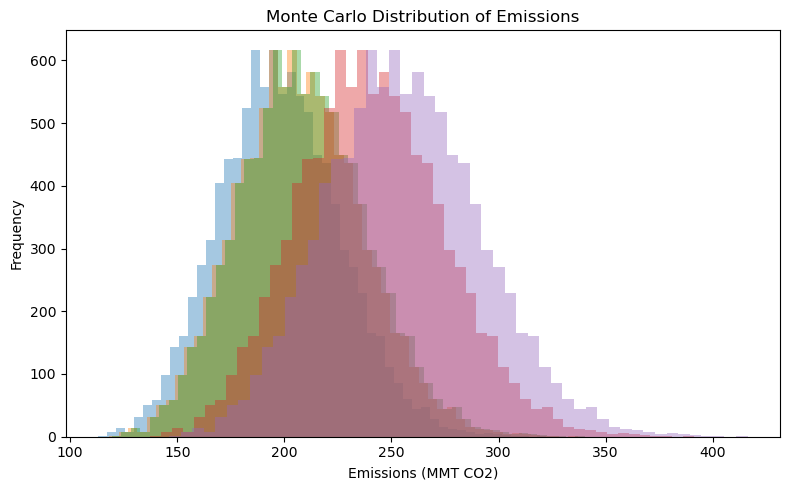

In [8]:
plt.figure(figsize=(8, 5))

for policy in summary.index:
    subset = mc[mc["Policy"] == policy]
    plt.hist(subset["Emissions_MMT"], bins=50, alpha=0.4)

plt.xlabel("Emissions (MMT CO2)")
plt.ylabel("Frequency")
plt.title("Monte Carlo Distribution of Emissions")
plt.tight_layout()
plt.show()


In [9]:
mc.columns


Index(['Policy', 'Y_TWh', 'C_g_per_kWh', 'Emissions_MMT', 'Abatement_MMT',
       'Abatement_%', 'Sim'],
      dtype='object')

In [10]:
baseline = mc.loc[mc["Policy"] == "Baseline", ["Sim", "Emissions_MMT"]].rename(
    columns={"Emissions_MMT": "Baseline_Emissions"}
)

merged = mc.merge(baseline, on="Sim", how="left")

prob_beats = (
    merged.loc[merged["Policy"] != "Baseline"]
    .assign(beats=lambda d: d["Emissions_MMT"] < d["Baseline_Emissions"])
    .groupby("Policy")["beats"]
    .mean()
    .sort_values(ascending=False)
    .round(3)
)

prob_beats


Policy
Carbon Tax ($30/ton)          1.0
Clean Energy Mandate (50%)    1.0
Clean Energy Subsidy          1.0
Dynamic Energy Pricing        1.0
Name: beats, dtype: float64

In [11]:
tail_risk = (
    mc.groupby("Policy")["Emissions_MMT"]
    .apply(lambda x: (x > 250).mean())
    .sort_values()
    .round(3)
)

tail_risk


Policy
Clean Energy Subsidy          0.037
Carbon Tax ($30/ton)          0.075
Dynamic Energy Pricing        0.086
Clean Energy Mandate (50%)    0.380
Baseline                      0.549
Name: Emissions_MMT, dtype: float64

In [12]:
baseline_mean = summary.loc["Baseline", "mean"]

expected_abatement = (baseline_mean - summary["mean"]).sort_values(ascending=False).round(3)

expected_abatement


Policy
Clean Energy Subsidy          57.664
Carbon Tax ($30/ton)          48.675
Dynamic Energy Pricing        46.672
Clean Energy Mandate (50%)    15.377
Baseline                       0.000
Name: mean, dtype: float64

In [13]:
# Wide format by simulation
mc_wide = mc.pivot(index="Sim", columns="Policy", values="Emissions_MMT")

# Abatement relative to baseline
abatement_wide = mc_wide["Baseline"].values.reshape(-1, 1) - mc_wide.values
abatement = pd.DataFrame(abatement_wide, columns=mc_wide.columns)
abatement.head()


Policy,Baseline,Carbon Tax ($30/ton),Clean Energy Mandate (50%),Clean Energy Subsidy,Dynamic Energy Pricing
0,0.0,50.330427,15.900030,59.625113,48.259076
1,0.0,59.654871,18.845742,70.671533,57.199772
2,0.0,46.370782,14.649127,54.934226,44.462389
3,0.0,60.619894,19.150605,71.814769,58.125079
4,0.0,48.852503,15.433135,57.874256,46.841976


In [14]:
policy_cost = {
    "Baseline": 0.00,
    "Carbon Tax ($30/ton)": -1.03,
    "Clean Energy Subsidy": -5.08,
    "Dynamic Energy Pricing": -4.72,
    "Clean Energy Mandate (50%)": -2.29,
}


In [15]:
cost_per_ton = {}

for policy in abatement.columns:
    if policy == "Baseline":
        continue

    cost = policy_cost[policy]  # in $ billions
    # convert billions to dollars, MMT to metric tons
    cost_dollars = cost * 1e9
    tons = abatement[policy] * 1e6

    cpt = cost_dollars / tons
    cost_per_ton[policy] = cpt

cost_per_ton = pd.DataFrame(cost_per_ton)
cost_per_ton.head()


,Carbon Tax ($30/ton),Clean Energy Mandate (50%),Clean Energy Subsidy,Dynamic Energy Pricing
0,-20.464758,-144.024885,-85.199000,-97.805437
1,-17.265983,-121.512859,-71.881843,-82.517812
2,-22.212263,-156.323308,-92.474225,-106.157138
3,-16.991122,-119.578467,-70.737539,-81.204191
4,-21.083873,-148.382038,-87.776507,-100.764323


In [16]:
cpt_summary = pd.DataFrame({
    "mean": cost_per_ton.mean(),
    "std": cost_per_ton.std(),
    "p5": cost_per_ton.quantile(0.05),
    "p95": cost_per_ton.quantile(0.95),
})

cpt_summary["range_90pct"] = cpt_summary["p95"] - cpt_summary["p5"]

cpt_summary = cpt_summary.round(2).sort_values("mean")

cpt_summary


,mean,std,p5,p95,range_90pct
Clean Energy Mandate (50%),-152.01,22.21,-192.33,-120.22,72.11
Dynamic Energy Pricing,-103.23,15.08,-130.61,-81.64,48.97
Clean Energy Subsidy,-89.92,13.14,-113.77,-71.12,42.66
Carbon Tax ($30/ton),-21.60,3.16,-27.33,-17.08,10.25


In [17]:
row_min = cost_per_ton.min(axis=1)
is_best = cost_per_ton.eq(row_min, axis=0)

prob_best = is_best.mean().sort_values(ascending=False).round(3)

prob_best


Clean Energy Mandate (50%)    1.0
Carbon Tax ($30/ton)          0.0
Clean Energy Subsidy          0.0
Dynamic Energy Pricing        0.0
dtype: float64